
# Support Vector Regression (SVR) using linear and non-linear kernels

Toy example of 1D regression using linear, polynomial and RBF kernels.   


출처   
https://scikit-learn.org/stable/modules/svm.html   
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py   



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import shap
import datetime

### Randomness 제어

In [3]:
seed = 27

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 데이터 가져오기



In [4]:
file_name = "dataset1.csv"
df = pd.read_csv(file_name)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('지점명', axis=1)
df = df.drop('년', axis=1)
df.head(2)

,5월평균기온,5월합강수량(mm),5월합계일조시간,6월평균기온,6월합강수량(mm),6월합계일조시간,7월평균기온,7월합강수량(mm),7월합계일조시간,8월평균기온,8월합강수량(mm),8월합계일조시간,단위면적당 생산량
0,14.2,20.2,151.1,18.0,356.5,107.6,22.0,189.4,128.3,23.0,200.0,135.8,438.0
1,16.2,355.6,135.0,19.8,113.0,110.7,24.2,73.3,218.3,24.7,60.3,170.5,451.0


### 데이터 전처리

#### 결측값 처리
결측값이 있는 행은 그냥 지워버렸음

In [5]:
miss_row = df[df.isna().any(axis=1)]
print(miss_row.size)
miss_row.head(2)

455


,5월평균기온,5월합강수량(mm),5월합계일조시간,6월평균기온,6월합강수량(mm),6월합계일조시간,7월평균기온,7월합강수량(mm),7월합계일조시간,8월평균기온,8월합강수량(mm),8월합계일조시간,단위면적당 생산량
790,16.1,29.2,215.0,21.4,203.9,158.2,25.7,162.9,197.7,NaN,NaN,10.7,505.0000
896,18.3,174.2,191.4,22.3,33.6,202.7,NaN,377.0,72.3,26.7,164.3,232.0,537.8724


In [6]:
df = df.dropna(axis=0)

### 데이터 나누기(train, test = 8 : 2)

In [7]:
X = df.loc[:, df.columns != '단위면적당 생산량']
y = df.loc[:, '단위면적당 생산량']

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
y_test = y_test_df.values
X_train.shape

(1594, 12)

#### 데이터 정규화 

In [8]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

X_train_scaler_df = pd.DataFrame(X_train_scaler, columns=X_train_df.columns)
X_val_scaler_df = pd.DataFrame(X_test_scaler, columns=X_test_df.columns)

### Fit regression model

함수 설명 : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR


### Experiment(하이퍼파라미터 튜닝)
출처 : https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/   
함수설명 : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html   
GridSearchCV에서 predefined validation set 사용방법: https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn

In [9]:
clf_ = SVR(kernel='rbf')
Cs = [60, 100, 140]
eps = [18, 20, 22]
Gammas = [0.05, 0.07, 0.09]

train_scaler_grid = GridSearchCV(SVR(), dict(C=Cs, epsilon=eps ,gamma=Gammas), refit=True, verbose=2)
# fitting the model for grid search
# train_grid.fit(X_train, y_train)
train_scaler_grid.fit(X_train_scaler, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................C=60, epsilon=18, gamma=0.05; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.05; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.05; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.05; total time=   0.2s
[CV] END .......................C=60, epsilon=18, gamma=0.05; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.07; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.07; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.07; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.07; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.07; total time=   0.1s
[CV] END .......................C=60, epsilon=18, gamma=0.09; total time=   0.1s
[CV] END .......................C=60, epsilon=1

GridSearchCV(estimator=SVR(),
             param_grid={'C': [60, 100, 140], 'epsilon': [18, 20, 22],
                         'gamma': [0.05, 0.07, 0.09]},
             verbose=2)

### 파일 저장 serial number

In [10]:
serial = datetime.datetime.now().strftime("%H:%M:%S")
serial = serial.replace(':', '-')
serial

'17-55-50'

### 시각화

In [11]:
loss_df = pd.DataFrame(train_scaler_grid.cv_results_)
loss_df['params'].head(5)

0    {'C': 60, 'epsilon': 18, 'gamma': 0.05}
1    {'C': 60, 'epsilon': 18, 'gamma': 0.07}
2    {'C': 60, 'epsilon': 18, 'gamma': 0.09}
3    {'C': 60, 'epsilon': 20, 'gamma': 0.05}
4    {'C': 60, 'epsilon': 20, 'gamma': 0.07}
Name: params, dtype: object

(3, 3, 3)


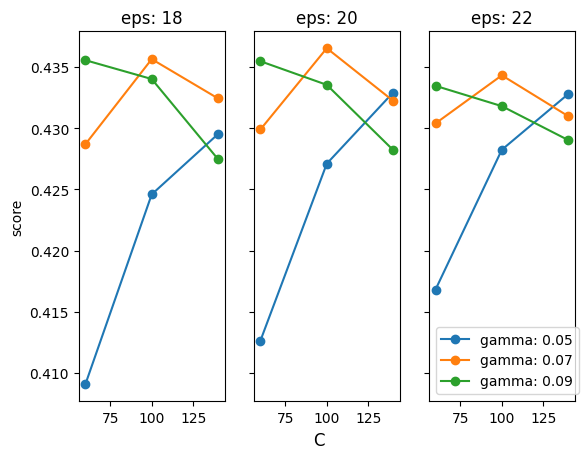

In [12]:
score = loss_df['mean_test_score'].values.reshape(len(Cs), len(eps), len(Gammas)) # {Cs, eps, Gammas}
score = score.swapaxes(0, 2) # {Gamma, eps, Cs}
print(score.shape)

fig, ax = plt.subplots(1, len(eps), sharex=True, sharey=True, width_ratios=[1]*len(eps))
for eps_ind, eps_val in enumerate(eps):
    for ind, i in enumerate(Gammas):
        ax[eps_ind].plot(Cs, score[ind][eps_ind], label='gamma: ' + f'{i:0.1}', marker='o')
        ax[eps_ind].set(ylabel='score' if eps_ind == 0 else '', title=f'eps: {eps_val}')

fig.supxlabel('C')
plt.legend()
plt.show()
# plt.savefig(f'C_MSE_{serial}.png', dpi=400)

(3, 3, 3)


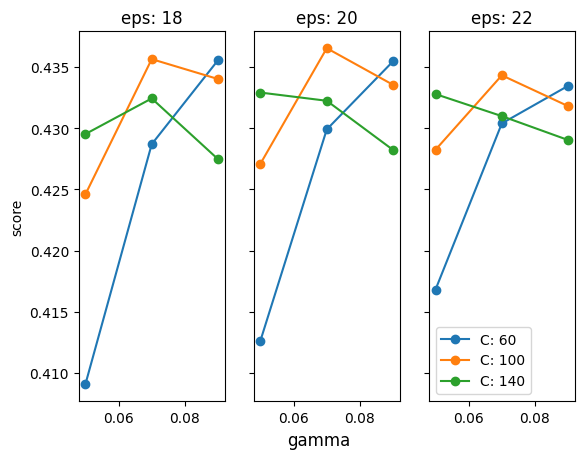

In [153]:
score = loss_df['mean_test_score'].values.reshape(len(Cs), len(eps), len(Gammas)) # {Cs, eps, Gammas}
print(score.shape)

fig, ax = plt.subplots(1, len(eps), sharey=True, width_ratios=[1]*len(eps))
for eps_ind,eps_val in enumerate(eps):
    for ind, i in enumerate(Cs):
        ax[eps_ind].plot(Gammas, score[ind][eps_ind], label='C: ' + str(i), marker='o')
        ax[eps_ind].set(ylabel='score' if eps_ind == 0 else '', title=f'eps: {eps_val}')

fig.supxlabel('gamma')
plt.legend()
plt.show()
# plt.savefig(f'gamma_MSE_{serial}.png', dpi=400)

### validation

best parameter {'C': 100, 'epsilon': 20, 'gamma': 0.07}
val_MSE : 871.2180250790556


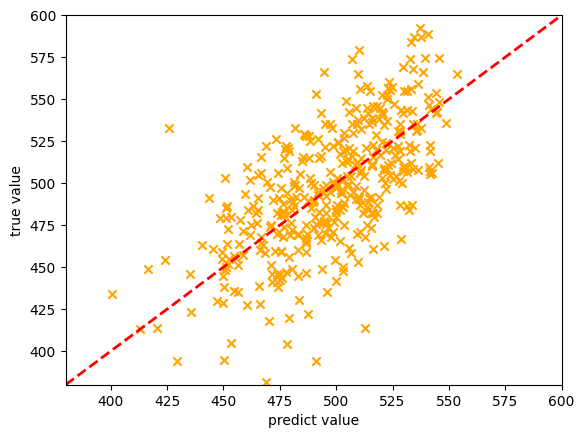

In [13]:
print("best parameter", train_scaler_grid.best_params_)
pred = train_scaler_grid.predict(X_test_scaler)
loss = mean_squared_error(pred, y_test)
print(f"val_MSE : {loss}")
l = 380
r = 600
I = np.arange(l, r)
plt.plot(I, I, color='red', lw=2, linestyle='--')
plt.scatter(pred, y_test, color='orange', marker='x')
plt.xlim([l, r])
plt.ylim([l, r])
plt.xlabel('predict value')
plt.ylabel('true value')
plt.show()
# plt.savefig(f'result_{serial}.png', dpi=400)

### Feature가 모델에 미치는 영향 분석

In [14]:
# X_train_scaler_sample = X_train_scaler_df.sample(100)
# X_val_scaler_sample = X_val_scaler_df.sample(100)

https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Iris%20classification%20with%20scikit-learn.html

In [15]:
# explainer = shap.KernelExplainer(train_scaler_grid.predict, X_train_scaler_sample)
# shap_value = explainer.shap_values(X_val_scaler_sample)

### shap 모델 로드

In [16]:
import pickle

with open('shap_svr_23-54-13.pkl', 'rb') as f:
     shap_value = pickle.load(f)

with open('svr_train_23-54-13.pkl', 'rb') as f:
     X_train_scaler_sample = pickle.load(f)

with open('svr_val_23-54-13.pkl', 'rb') as f:
     X_val_scaler_sample = pickle.load(f)

### shap 한글폰트 설정

In [17]:
shap.matplotlib.rc('font', family='Malgun Gothic') #한글 폰트
shap.matplotlib.rcParams['axes.unicode_minus'] = False
n_jobs = -1

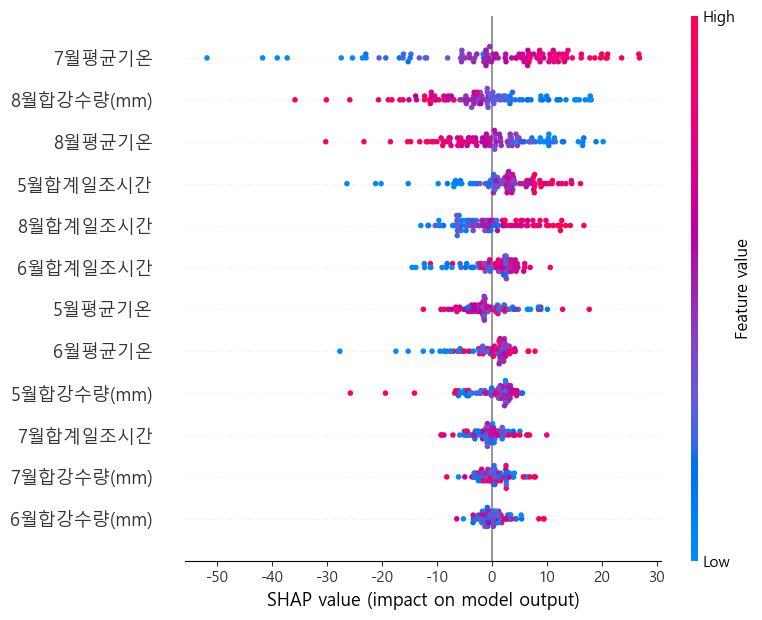

In [18]:
shap.summary_plot(shap_value, X_val_scaler_sample)

### shap 모델 저장

In [185]:
# import pickle

# with open(f'shap_svr_{serial}.pkl', "wb") as f:
#     pickle.dump(shap_value, f)

# with open(f'svr_train_{serial}.pkl', "wb") as f:
#     pickle.dump(X_train_scaler_sample, f)

# with open(f'svr_val_{serial}.pkl', "wb") as f:
#     pickle.dump(X_val_scaler_sample, f)